# Designing adaptive experiments to study working memory

In most of machine learning, we begin with data and go on to learn a model. In other contexts, we also have a hand in the data generation process. This gives us an exciting opportunity: we can try to obtain data that will help our model learn more effectively. This procedure is called *optimal experimental design* (OED) and Pyro supports choosing optimal designs through the `pyro.contrib.oed` module.

When using OED, the data generation and modelling works as follows:
1. Write down a Bayesian model involving a design parameter, an unknown latent variable and an observable.
2. Choose the optimal design (more details on this later).
3. Collect the data and fit the model, e.g. using `SVI`.

We can also run multiple 'rounds' or iterations of experiments. When doing this, we take the learned model from step 3 and use it as our prior in step 1 for the next round. This approach can be particularly useful because it allows us to design the next experiment based on what has already been learned: the experiments are *adaptive*.

In this tutorial, we work through a specific example of this entire OED procedure with multiple rounds. We will show how to design adaptive experiments to learn a participant's working memory capacity. The design we will be adapting is the *length of a sequence of digits that we ask a participant to remember*. Let's dive into the full details.


### The experiment set-up
Suppose you, the participant, are shown a sequence of digits

$$ 1\ 4\ 7\ 0\ 9 $$

which are then hidden. You have to to reproduce the sequence exactly from memory. In the next round, the length of the sequence may be different

$$ 6\ 5\ 0\ 2\ 8\ 0 .$$

The longest sequence that you can remember is your working memory capacity. In this tutorial, we build a Bayesian model for working memory, and use it to run an adaptive sequence of experiments that very quickly learn someone's working memory capacity.


## A model of working memory
Our model for a single round of the digits experiment described above has three components: the length $l$ of the sequence that the participant has to remember, the participant's true working memory capacity $\theta$, and the outcome of the experiment $y$ which indicates whether they were able to remember the sequence successfully ($y=1$) or not ($y=0$). We choose a prior for working memory capacity based on the (in)famous "The magical number seven, plus or minus two" [1].

**Note**: $\theta$ actually represents the point where the participant has a 50/50 chance of remembering the sequence correctly.

In [1]:
import torch

import pyro
import pyro.distributions as dist


sensitivity = 1.0
prior_mean = torch.tensor(7.0)
prior_sd = torch.tensor(2.0)


def model(l):
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    # This line defines a *logistic regression* model for y
    logit_p = sensitivity * (theta - l)
    y = pyro.sample("y", dist.Bernoulli(logits=logit_p))
    return y

The probability of successfully remembering the sequence is plotted below, for five random samples of $\theta$.

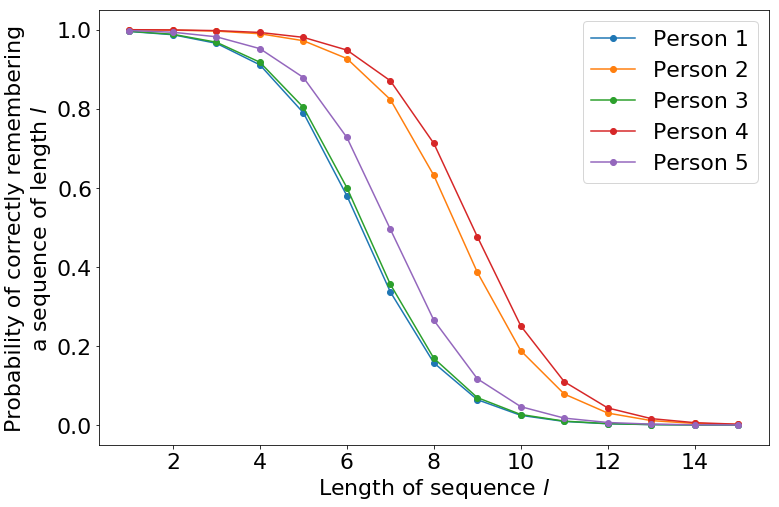

In [19]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

# We sample five times from the prior
theta = (prior_mean + prior_sd * torch.randn((5,1)))
l = torch.arange(1, 16, dtype=torch.float)
# This is the same as using 'logits=' in the prior above
prob = torch.sigmoid(sensitivity * (theta - l))

plt.figure(figsize=(12, 8))
for curve in torch.unbind(prob, 0):
    plt.plot(l.numpy(), curve.numpy(), marker='o')
plt.xlabel("Length of sequence $l$")
plt.ylabel("Probability of correctly remembering\na sequence of length $l$")
plt.legend(["Person {}".format(i+1) for i in range(5)])
plt.show()

## Inference in the model

With the model in hand, we quickly demonstrate variational inference in Pyro for this model. We will set up the inference to handle any number of rounds.

In [3]:
from contextlib import ExitStack
from pyro.contrib.util import rexpand

def multiround_model(l):
    # The shape of l is (*batch dims, number of rounds)
    batch_dims = l.shape[:-1]
    with ExitStack() as stack:
        for i, dim in enumerate(batch_dims[::-1]):
            stack.enter_context(pyro.plate("plate" + str(i), dim))
        theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
        # Share theta across the number of rounds of the experiment
        # This represents repeatedly testing the same participant
        theta = rexpand(theta, l.shape[-1])
        logit_p = sensitivity * (theta - l)
        # The shape of y is (*batch dims, number of rounds)
        # The event shape represents responses from the same participant
        y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
        return y

We also define a Normal guide for variational inference.

In [4]:
from torch.distributions.constraints import positive

def guide(l):
    # The guide is initialised at the prior
    posterior_mean = pyro.param("posterior_mean", prior_mean.clone())
    posterior_sd = pyro.param("posterior_sd", prior_sd.clone(), constraint=positive)
    pyro.sample("theta", dist.Normal(posterior_mean, posterior_sd))

We finally specify the following data: the participant was shown sequences of lengths 5, 7 and 9. They remembered the first two correctly, but not the third one.

In [5]:
l_data = torch.tensor([5., 7., 9.])
y_data = torch.tensor([1., 1., 0.])

We can now run SVI on the model.

In [6]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

conditioned_model = pyro.condition(multiround_model, {"y": y_data})
svi = SVI(conditioned_model,
          guide,
          Adam({"lr": .001}),
          loss=Trace_ELBO(),
          num_samples=100)
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(l_data)
    if i % 500 == 0:
        print("Neg ELBO:", elbo)

Neg ELBO: 1.0052146911621094
Neg ELBO: 1.099194884300232
Neg ELBO: 1.8430355787277222
Neg ELBO: 1.0629709959030151
Neg ELBO: 1.117399513721466
Neg ELBO: 1.2539764642715454
Neg ELBO: 1.2148146629333496
Neg ELBO: 1.2692784667015076
Neg ELBO: 1.2362917065620422
Neg ELBO: 1.238534152507782


In [7]:
print("Prior:     N({:.3f}, {:.3f})".format(prior_mean, prior_sd))
print("Posterior: N({:.3f}, {:.3f})".format(pyro.param("posterior_mean"),
                                            pyro.param("posterior_sd")))

Prior:     N(7.000, 2.000)
Posterior: N(7.692, 1.258)


Under our posterior, we can see that we have an updated estimate for the participant's working memory capacity, and our uncertainty has now decreased.

## Bayesian optimal experimental design
So far so standard. In the previous example, the lengths `l_data` were not chosen with a great deal of forethought. Fortunately, in a setting like this, it is possible to use a more sophisticated strategy to choose the sequence lengths to make the most of every question we ask.

We do this using Bayesian optimal experimental design (BOED). In BOED, we are interested in designing experiments that maximise the information gain, which is defined formally as

$$ \text{IG}(l, y) = KL(p(\theta|y,l)||p(\theta)) .$$

where $KL$ represents the [Kullback-Leiber divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In words, the information gain is the KL divergence from the posterior to the prior. It therefore represents the distance we "move" the posterior by running an experiment with length $l$ and getting back the outcome $y$.

Unfortunately, we will not know $y$ until we actually run the experiment. Therefore, we choose $l$ on the basis of the *expected* information gain [2]

$$\text{EIG}(l) = \mathbb{E}_{y\sim p(y|\theta,l)}\quad [KL(p(\theta|y,l)||p(\theta))]. $$

Because it features the posterior density $p(y|\theta,l)$, the EIG is not immediately tractable. However, we can make use of the following variational estimator for EIG [3]

$$\text{EIG}(l) = \min_q \mathbb{E}_{\theta,y \sim p(\theta)p(y|\theta,l)}\quad \left[ \log \frac{p(y|\theta,l)}{q(y)} \right].$$

### Optimal experimental design in Pyro
Fortunately, Pyro comes ready with tools to estimate the EIG. All we have to do is define the "marginal guide" $q(y)$ in the formula above.

In [8]:
def marginal_guide(design, observation_labels, target_labels):
    p_logit = pyro.param("p_logit", torch.zeros(design.shape[-2:]))
    pyro.sample("y", dist.Bernoulli(logits=p_logit).to_event(1))

In [9]:
from pyro.contrib.oed.eig import marginal_eig

# The shape is (number designs, 1)
# This represents a batch of candidate designs, each design is for one round of experiment
candidate_designs = torch.arange(1, 15, dtype=torch.float).unsqueeze(-1)
pyro.clear_param_store()

# Pre-train
marginal_eig(multiround_model,        # model
             candidate_designs,       # design, or in this case, tensor of possible designs
             "y",                     # site label of observations, could be a list
             "theta",                 # site label of 'targets' (latent variables), could also be list 
             num_samples=100,         # number of samples to draw per step in the expectation
             num_steps=500,           # number of gradient steps
             guide=marginal_guide,    # guide q(y)
             optim=Adam({"lr": 0.1})  # optimizer. Here we use a large learning rate to pre-train
            )
# Compute EIG
eig = marginal_eig(multiround_model,           # everything is the same as above ...
                   candidate_designs,
                   "y",
                   "theta",
                   num_samples=100,
                   num_steps=1000,
                   guide=marginal_guide,
                   optim=Adam({"lr": 0.002}),  # except we now use a smaller learning rate
                   final_num_samples=10000     # and, at the last step, we draw more samples
                                               # for a more accurate EIG estimate
                  )

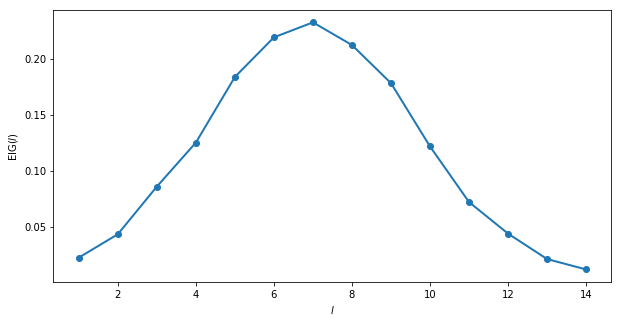

In [10]:
plt.figure(figsize=(10,5))
plt.plot(candidate_designs.numpy(), eig.detach().numpy(), marker='o', linewidth=2)
plt.xlabel("$l$")
plt.ylabel("EIG($l$)")
plt.show()

In [11]:
best_l = 1 + torch.argmax(eig)
print("Optimal design:", best_l.item())

Optimal design: 7


This tells us that the first round should be run with a sequence of length 7. Note that, while we might have been able to guess this optimal design intuitively, this same framework applies equally well to more sophisticated models and experiments where finding the optimal design by intuition is more challenging.

## The adaptive experiment

We now have the ingredients to build an adaptive experiment to study working memory. We repeat the following steps:
1. Use the EIG to find the optimal sequence length $l$
2. Run the test using a sequence of length $l$
3. Update the posterior distribution with the new data


At the first iteration, step 1 is done using the prior as above. However, for subsequent iterations, we use the posterior given all the data so far.

In this notebook, the "experiment" is performed using the following synthesiser

In [12]:
def synthetic_person(l):
    # The synthetic person can remember any sequence shorter than 6
    # They cannot remember any sequence of length 6 or above
    # (There is no randomness in their responses)
    y = (l < 6.).float()
    return y

The following code allows us to update the model as we gather more data.

In [13]:
def make_model(mean, sd):
    def model(l):
        # The shape of l is (*batch dims, number of rounds)
        batch_dims = l.shape[:-1]
        with ExitStack() as stack:
            for i, dim in enumerate(batch_dims[::-1]):
                stack.enter_context(pyro.plate("plate" + str(i), dim))
            theta = pyro.sample("theta", dist.Normal(mean, sd))
            # Share theta across the number of rounds of the experiment
            # This represents repeatedly testing the same participant
            theta = rexpand(theta, l.shape[-1])
            logit_p = sensitivity * (theta - l)
            # The shape of y is (*batch dims, number of rounds)
            # The event shape represents responses from the same participant
            y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
            return y
    return model

Now we have everything to run a 10-step experiment using adaptive designs.

In [14]:
ys = torch.tensor([])
ls = torch.tensor([])
history = [(prior_mean, prior_sd)]
pyro.clear_param_store()
model = make_model(prior_mean, prior_sd)

for experiment in range(10):
    print("Round", experiment + 1)
     
    # Step 1: compute the optimal length
    # Pre-train
    marginal_eig(model, candidate_designs, "y", "theta", num_samples=100,
                 num_steps=500, guide=marginal_guide, optim=Adam({"lr": 0.1}))
    # Compute EIG
    eig = marginal_eig(model, candidate_designs, "y", "theta", num_samples=100,
                       num_steps=500, guide=marginal_guide, optim=Adam({"lr": 0.002}),
                       final_num_samples=10000)
    best_l = 1 + torch.argmax(eig).float().detach()
    
    # Step 2: run the experiment, here using the synthetic person
    print("Asking the participant to remember a sequence of length", int(best_l.item()))
    y = synthetic_person(best_l)
    if y:
        print("Participant remembered correctly")
    else:
        print("Participant could not remember the sequence")
    # Store the sequence length and outcome
    ls = torch.cat([ls, best_l.expand(1)], dim=0)
    ys = torch.cat([ys, y.expand(1)])
    
    # Step 3: learn the posterior using all data seen so far
    conditioned_model = pyro.condition(multiround_model, {"y": ys})
    svi = SVI(conditioned_model,
              guide,
              Adam({"lr": .005}),
              loss=Trace_ELBO(),
              num_samples=100)
    num_iters = 2000
    for i in range(num_iters):
        elbo = svi.step(ls)
        
    history.append((pyro.param("posterior_mean").detach().clone().numpy(),
                    pyro.param("posterior_sd").detach().clone().numpy()))
    model = make_model(pyro.param("posterior_mean").detach().clone(),
                       pyro.param("posterior_sd").detach().clone())
    print("Estimate of \u03b8: {:.3f} \u00b1 {:.3f}\n".format(*history[-1]))

Round 1
Asking the participant to remember a sequence of length 7
Participant could not remember the sequence
Estimate of θ: 5.743 ± 1.541

Round 2
Asking the participant to remember a sequence of length 5
Participant remembered correctly
Estimate of θ: 6.470 ± 1.331

Round 3
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence
Estimate of θ: 5.658 ± 1.230

Round 4
Asking the participant to remember a sequence of length 5
Participant remembered correctly
Estimate of θ: 6.131 ± 1.059

Round 5
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence
Estimate of θ: 5.616 ± 0.895

Round 6
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence
Estimate of θ: 5.308 ± 0.809

Round 7
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence
Estimate of θ: 5.180 ± 0.793

Round 8
Asking the participant to remember

Now let's visualize the evolution of the posterior over $\theta$:

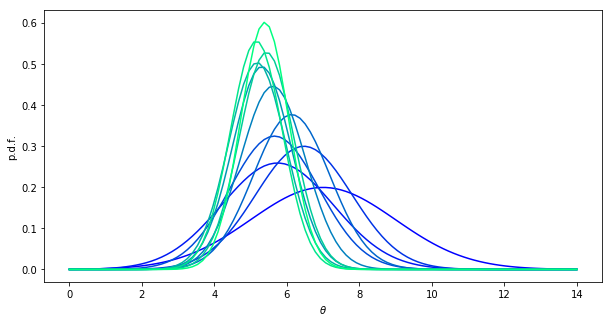

In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.colors as colors
import matplotlib.cm as cmx


cmap = plt.get_cmap('winter') 
cNorm  = colors.Normalize(vmin=0, vmax=len(history)-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
plt.figure(figsize=(10, 5))
x = np.linspace(0, 14, 100)
for idx, (mean, sd) in enumerate(history):
    color = scalarMap.to_rgba(idx)
    y = norm.pdf(x, mean, sd)
    plt.plot(x, y, color=color)
    plt.xlabel("$\\theta$")
    plt.ylabel("p.d.f.")
plt.show()

(Blue = prior, light green = 10 step posterior)

By contrast, suppose we use a simplistic design: try sequences of lengths 1, 2, ..., 10.

In [16]:
pyro.clear_param_store()
ls = torch.arange(1, 11, dtype=torch.float)
ys = synthetic_person(ls)
conditioned_model = pyro.condition(multiround_model, {"y": ys})
svi = SVI(conditioned_model,
          guide,
          Adam({"lr": .005}),
          loss=Trace_ELBO(),
          num_samples=100)
num_iters = 2000
for i in range(num_iters):
    elbo = svi.step(ls)

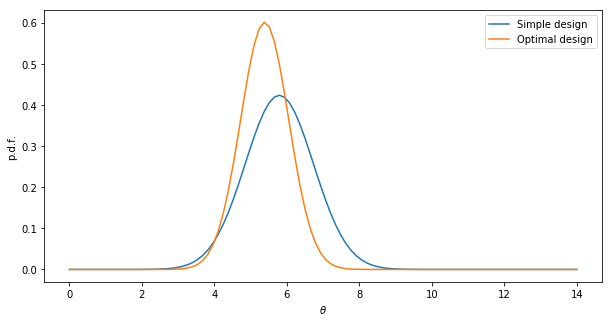

In [17]:
plt.figure(figsize=(10,5))
y1 = norm.pdf(x, pyro.param("posterior_mean").detach().numpy(),
              pyro.param("posterior_sd").detach().numpy())
y2 = norm.pdf(x, history[-1][0], history[-1][1])
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(["Simple design", "Optimal design"])
plt.xlabel("$\\theta$")
plt.ylabel("p.d.f.")
plt.show()

Although both design strategies give us data, the optimal strategy ends up with a posterior distribution that is more peaked: that means we have greater confidence in our final answer, or may be able to stop experimenting earlier.

## Extensions

In this tutorial we used variational inference to fit an approximate posterior for $\theta$. This could be substituted for an alternative posterior inference strategy, such as Hamiltonian Monte Carlo. 

The model in this tutorial is very simple and could be extended in a number of ways. For instance, it's possible that as well as measuring whether the participant did or did not remember the sequence, we might collect some other information as well. We could build a model for the number of mistakes made (e.g. the edit distance between the correct sequence and the participant's response) or jointly model the correctness and the time taken to respond. Here is an example model where we model the response time using a LogNormal distribution, as suggested by [4].

In [18]:
time_intercept = 0.5
time_scale = 0.5

def model(l):
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    logit_p = sensitivity * (theta - l)
    correct = pyro.sample("correct", dist.Bernoulli(logits=logit_p))
    mean_log_time = time_intercept + time_scale * (theta - l)
    time = pyro.sample("time", dist.LogNormal(mean_log_time, 1.0))
    return correct, time

It would still be possible to compute the EIG using `marginal_eig`. We would replace `"y"` by `["correct", "time"]` and the marginal guide would now model a joint distribution over the two sites `"correct"` and `"time"`.

Our model also made a number of assumptions that we may choose to relax. For instance, we assumed that all sequences of the same length are equally easy to remember. We also fixed the `sensitivity` to be a known constant: it's likely we would need to learn this. We could also think about learning at two levels: learning global variables for population trends as well as local variables for individual level effects. The current model is an individual only model. The EIG could still be used as a means to select the optimal design in such scenarios.

## References

[1] Miller, G.A., 1956. **The magical number seven, plus or minus two: Some limits on our capacity for processing information.** Psychological review, 63(2), p.81.

[2] Chaloner, K. and Verdinelli, I., 1995. **Bayesian experimental design: A review.** Statistical Science, pp.273-304.

[3] Foster, A., Jankowiak, M., Bingham, E., Horsfall, P., Teh, Y.W., Rainforth, T. and Goodman, N., 2019. **Variational Bayesian Optimal Experimental Design.** Advances in Neural Information Processing Systems 2019 (to appear).

[4] van der Linden, W.J., 2006. **A lognormal model for response times on test items.** Journal of Educational and Behavioral Statistics, 31(2), pp.181-204.